# Clustering for Customer Segmentation with KMeans


## Key Takeaways
In this module, students will gain a comprehensive understanding of KMeans clustering and its applications in customer segmentation. 

__They will learn how to:__
- choose the optimal number of clusters, 
- visualize cluster results, and 
- apply clustering techniques to real-world datasets. 

Through practical exercises and projects, students will develop the skills necessary to leverage clustering for data-driven decision-making in various domains.

## Introduction to Clustering
- Definition of Clustering
- Unsupervised Learning vs. Supervised Learning
- Applications of Clustering in Data Science
- Types of Clustering Algorithms: Partitioning, Hierarchical, Density-Based, Model-Based


## KMeans Algorithm

__Overview of KMeans Clustering__

___How KMeans Works:___
1. Initialization: Randomly select initial cluster centroids
2. Assignment: Assign each data point to the nearest cluster centroid
3. Update: Recalculate the cluster centroids based on the mean of data points in each cluster
4. Repeat Assignment and Update steps until convergence

__Determining the Optimal Number of Clusters:__
1. Elbow Method
2. Silhouette Score

## Choosing the Optimal Number of Clusters

__Elbow Method:__
- Explanation of Elbow Method
- Plotting the Within-Cluster Sum of Squares (WCSS) against the number of clusters
- Identifying the "elbow" point where the rate of decrease in WCSS slows down

__Silhouette Score:__
- Explanation of Silhouette Score
- Calculating the Silhouette Score for different numbers of clusters
- Choosing the number of clusters with the highest Silhouette Score

## Visualizing Clusters

__Techniques for Visualizing Cluster Results:__
- Scatter plots with cluster centroids
- Cluster profiles: Mean feature values for each cluster
- Cluster heatmaps: Visualizing cluster characteristics

__Interpreting and Analyzing Cluster Results:__
- Identifying distinct customer segments or groups
- Understanding the characteristics and behaviors of each cluster
- Extracting insights for business decisions and marketing strategies

## Applications in Market Segmentation

__How data science helps:__

- Businesses analyze customer data to create targeted marketing strategies that cater to specific groups (segments), improving engagement and loyalty.

__Types of customer segmentation features:__

- Demographic, Geographic, Psychographic, and Behavioural.

__Demographic__ - grouping is based on demographic variables such as age, gender, income, occupation, and education level. 

__Geographic__ - group according to their location, which could be as broad as a country or as specific as a neighborhood. This helps in tailoring marketing campaigns that are culturally and regionally relevant. 

__Psychographic__ - includes lifestyle, values, attitudes, and personal traits. 

__Behavioural__ - customers are divided based on their behaviour patterns related to the business, such as purchase history, product usage frequency, brand loyalty, and user status (new, potential, or loyal customers).

__What data do I regularly segment on for Email Marketing Segmentation?__ 

Recency Frequency Monetary (RFM) features, time on list, time since last purchase, spend in last 30 days, products purchased, interests (what they clicking on), events attended, email scoring, clicked on a product page (which ones?), geographic region, number of tags, number of events, and many more.

__Algorithms used:__

- KMeans - great tool for finding similar customers.


In [175]:
# Libraries

# Data manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Date manipulation
from datetime import date, datetime, timedelta

# Clustering algorithm
from sklearn.cluster import KMeans

# For Cat features
from category_encoders import OneHotEncoder
# For Scaling features
from sklearn.preprocessing import StandardScaler
# Model pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
# Evaluation metric
from sklearn.metrics import silhouette_score

In [176]:
# import data
raw_df = pd.read_csv('./data/marketing_campaign.csv')
print(raw_df.info())
raw_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [177]:
def prepare_data(data):

    data = (
        data
        # Remove NA values
        .dropna()
        # Convert Dt_Customer datatype to Date
        .assign(
            Dt_Customer = lambda x: pd.to_datetime(x['Dt_Customer'], format="%d-%m-%Y")
            )
        # Feature: Customer Age - max customer date
        .assign(
            Cust_Age = lambda x: -1*(x['Dt_Customer'] - x['Dt_Customer'].min())/timedelta(days=1)
            )
        # Spent = Sum(Mnt...)
        .assign(
            Spent = lambda x: x.loc[:,x.columns.str.contains('Mnt')].agg(
                ['sum'], #function to use
                axis=1 # tell pandas to aggregate each row
                )
            )
        # Remove unnecessary features
        .drop(
            columns = ['ID', 'Z_CostContact', 'Z_Revenue', 'Response', 'Dt_Customer']
            )
        )
    prepared_df = OneHotEncoder(use_cat_names=True).fit_transform(data)
    return prepared_df

In [178]:
# Features to use
X = prepare_data(raw_df)
X.head()

,Year_Birth,Education_Graduation,Education_PhD,Education_Master,Education_Basic,Education_2n Cycle,Marital_Status_Single,Marital_Status_Together,Marital_Status_Married,Marital_Status_Divorced,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Cust_Age,Spent
0,1957,1,0,0,0,0,1,0,0,0,...,4,7,0,0,0,0,0,0,-36.0,1617
1,1954,1,0,0,0,0,1,0,0,0,...,2,5,0,0,0,0,0,0,-586.0,27
2,1965,1,0,0,0,0,0,1,0,0,...,10,4,0,0,0,0,0,0,-387.0,776
3,1984,1,0,0,0,0,0,1,0,0,...,4,6,0,0,0,0,0,0,-560.0,53
4,1981,0,1,0,0,0,0,0,1,0,...,6,5,0,0,0,0,0,0,-538.0,422


In [179]:
n_clusters = range(2,8)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # Build model
    model = make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=k, random_state=42)
    )
    # Train model
    model.fit(X)
    # Calculate inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculate silhouette score
    silhouette_scores.append(
        silhouette_score(
            X, 
            model.named_steps["kmeans"].labels_)
    )

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [69062.98161331186, 65318.95533249145, 63721.78064506085]

Silhouette Scores: [0.4795937807812199, 0.28920162950694633, 0.14962618066425873]


In [180]:
import plotly.express as px
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters,
    y=inertia_errors,
    title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

In [187]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = fig = px.line(
    x=n_clusters,
    y=silhouette_scores,
    title="K-Means Model: Silhouette Score vs Number of Clusters (Elbow Method)"
)
fig.update_layout(
    xaxis_title="Number of Clusters", yaxis_title="Silhouette Score"
)
fig.show()

In [182]:
# final_model labels
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=6, random_state=42)
)
# Predict class labels
labes = final_model.fit_predict(X)
print(labels[:10])

[2 3 2 0 0 1 1 0 0 0]


In [183]:
X['labels'] = final_model.named_steps["kmeans"].labels_
print(labels[:10])

[2 3 2 0 0 1 1 0 0 0]


c:\Users\Eddie\anaconda3\envs\mlg-382-class\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


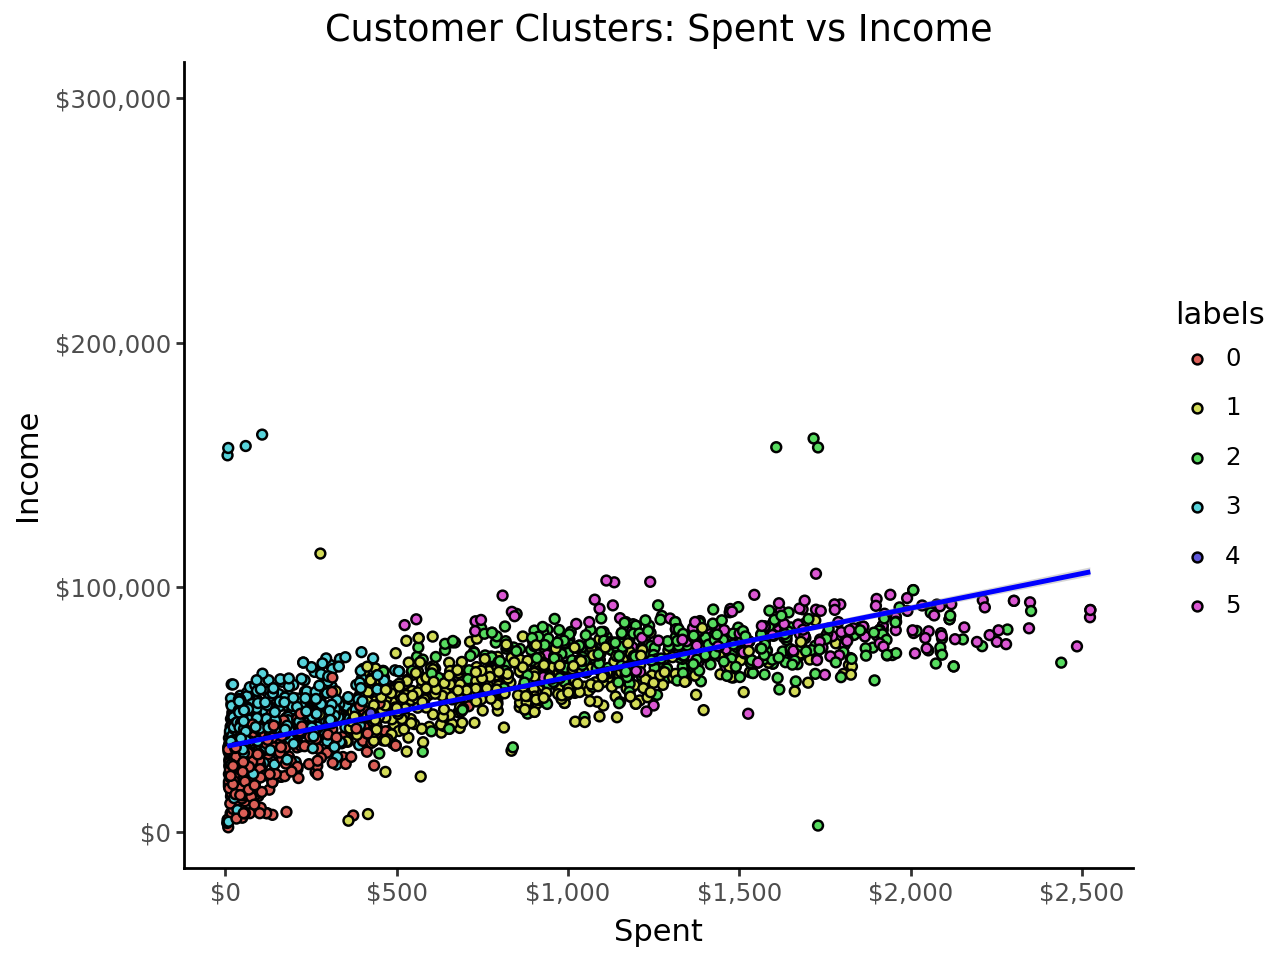

In [184]:
import plotnine as pn
from plotnine import *
p = (
    ggplot(X, aes(x='Spent', y='Income')) + geom_point(aes(fill = X['labels'].astype(str)))
    )
p = p + geom_smooth(color = "blue", se = True)
p = p + scale_x_continuous(name='Spent', labels = lambda x: [f'${y:,.0f}' for y in x])
p = p + scale_y_continuous(name='Income', labels = lambda x: [f'${x:,.0f}' for x in x], limits=(0,300_000))
p = p + labs(title = "Customer Clusters: Spent vs Income") + theme_classic()
# p = ggplotly(p)
p.show()

In [185]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)
X_t
# # Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (2216, 2)


,PC1,PC2
0,5910.615144,-1032.251471
1,-5914.687577,584.754127
2,19365.921182,169.741243
3,-25608.791777,192.914839
4,6040.491882,360.320442


In [186]:
# Create scatter plot
fig = px.scatter(
    data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels.astype(str),
    title="Customer Clusters: Spent vs Income"
)
fig.update_layout(xaxis_title="Spent", 
                  yaxis_title="Income")
fig.show()

c:\Users\Eddie\anaconda3\envs\mlg-382-class\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
